In [1]:
!pip install einops
!pip install timm

     |████████████████████████████████| 431 kB 5.0 MB/s            


In [2]:
import torch
# from vit_pytorch import ViT, MAE
from glob import glob
from torch.utils.data import Dataset, DataLoader
import os
# from skimage import io, transform
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from timm.models.vision_transformer import PatchEmbed, Block
from functools import partial
import sys
import os
import requests

In [3]:
from skimage import io
im = io.imread('../input/neuron/train-input.tif')
print(im.shape)

(100, 1024, 1024)


## 2D SlicesDataGenerator

In [4]:
# train, val = train_test_split(image, test_size=0.2)
train, val = im[0:80, :, :], im[80:, :, :]

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class SliceDataLoader(Dataset):
    def __init__(self,input_vol,size, transform=None):
        
        self.vol = input_vol
        self.x, _, _ = input_vol.shape
        self.length = size
        self.transform = transforms.Compose([
                                                transforms.ToTensor(),    
                                           ])
        self.randomlist = pd.DataFrame(np.concatenate((np.random.randint(0,800,size=(self.length, 2)), np.random.randint(0,self.x,size=(self.length, 1))), axis=1))
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x, y, z = self.randomlist.iloc[idx]
        image = self.vol[z, x:x+224, y:y+224]
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [7]:
class SliceDataLoader3D(Dataset):
    def __init__(self,input_vol,size, transform=None):
        
        self.vol = input_vol
        self.x, _, _ = input_vol.shape
        self.length = size
        self.transform = transforms.Compose([
                                                transforms.ToTensor(),    
                                           ])
        self.randomlist = pd.DataFrame(np.concatenate((np.random.randint(0,800,size=(self.length, 2)), np.random.randint(0,self.x,size=(self.length, 1))), axis=1))
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x, y, z = self.randomlist.iloc[idx]
        image = self.vol[z, x:x+224, y:y+224]
        image = np.stack((image,image,image), axis=2)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [8]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,input_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_list = input_dir
#         self.landmarks_frame = pd.read_csv(csv_file)
#         self.root_dir = root_dir
        self.transform = transforms.Compose([
                                               transforms.ToTensor(),
                                           ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_list.iloc[idx, 0])
        
        image = np.load(img_name)
        image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        if self.transform:
            image = self.transform(image)
            
#         print(image.shape)
        return image

In [9]:
# # train_set = FaceLandmarksDataset(image)
# train_set = FaceLandmarksDataset(train)
# val_set = FaceLandmarksDataset(val)
# # val_set = FaceLandmarksDataset(glob("../input/imagenetmini-1000/imagenet-mini/val/*/*.JPEG"))

In [10]:
# train_set = FaceLandmarksDataset(image)
train_set = SliceDataLoader(train, 500)
val_set = SliceDataLoader(val, 100)

In [11]:
BATCH_SIZE = 2 #25
WORKERS = 0
SHUFFLE = True
train_loader = DataLoader(train_set,  batch_size=BATCH_SIZE,
                        shuffle=SHUFFLE, num_workers=WORKERS)
val_loader = DataLoader(val_set,  batch_size=BATCH_SIZE,
                        shuffle=SHUFFLE, num_workers=WORKERS)

In [12]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [13]:
class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=1,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 1, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 1))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 1))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 1, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask

In [15]:
# mae = MaskedAutoencoderViT(
#         patch_size=16, embed_dim=768, depth=12, num_heads=12,
#         decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
#         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
mae = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
# mae = MaskedAutoencoderViT(
#         patch_size=14, embed_dim=1280, depth=32, num_heads=16,
#         decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
#         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))

In [ ]:
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
# !wget -nc https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_huge.pth

In [16]:
mae = mae.to(device)

In [ ]:
# checkpoint = torch.load("./mae_visualize_vit_large.pth", map_location='cuda')
# mae.load_state_dict(checkpoint['model'])

# mae.eval()

In [ ]:
# mae = mae.to(device)

In [18]:
# criterion = nn.MSELoss()
# if torch.cuda.is_available():
#     criterion = criterion.cuda()
# optimizer = torch.optim.Adam(mae.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(mae.parameters(), lr=0.001, betas=(0.9, 0.95))

In [ ]:

# if torch.cuda.is_available():
#     mae = mae.cuda()

!scp

In [19]:

pred = np.array
val_pred = np.array
loss_list = []
vloss_list = []

for epoch in range(800):  # loop over the dataset multiple times
    i=0
    running_loss = 0.0
    val_loss=0.0
    for data in tqdm(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        data = data.to(device)
        images = data
        i+=1
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
#         outputs = net(inputs)
        loss, pred, mask = mae(images)
#         loss = criterion(pred, masked)
        loss.backward()
        optimizer.step()
        if epoch%50==0:
#             torch.save(v.state_dict(), './trained-vit'+str(epoch)+'.pt')
            torch.save(mae, "./model"+str(epoch))
        # print statistics
        running_loss += loss.item()
    print('[%d] Training loss: %.5f' %
            (epoch + 1, running_loss/5))
    loss_list.append(running_loss)
    for data in tqdm(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        data = data.to(device)
        images = data
        i+=1
#         print(images.shape)
        val_loss, val_pred,val_mask = mae(images)
#         print(pred.shape)
#         loss = criterion(val_pred, val_masked)
#         if epoch%100==0:
#             torch.save(v.state_dict(), './trained-vit'+str(epoch)+'.pt')
#             torch.save(mae, "./model"+str(epoch))
        # print statistics
        val_loss += loss.item()
    print('[%d] Validation loss: %.5f' %
            (epoch + 1, val_loss))
    vloss_list.append(val_loss)

print('Finished Training')
# that's all!
# do the above in a for loop many times with a lot of images and your vision transformer will learn

# save your improved vision transformer
torch.save(mae, './trained-vit')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Visualisation

In [31]:
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 1
#     plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def run_one_image(img, model):
    x = torch.tensor(img)
#     x = x.unsqueeze(dim=2)
    # make it a batch-like
    x = x.unsqueeze(dim=0)
    print(x.shape)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    x = x.detach().cpu()
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()
    return loss

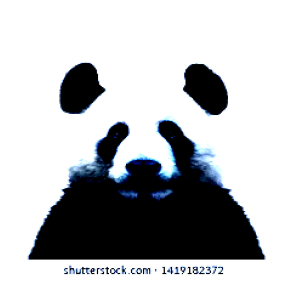

In [21]:
# load an image
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img_url = 'https://image.shutterstock.com/image-photo/panda-bear-face-isolated-on-260nw-1419182372.jpg'
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 1)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [ ]:
run_one_image(img, mae)

In [24]:
x.shape

(2, 1, 3, 224, 224)

torch.Size([2, 1, 224, 224])
torch.Size([224, 224, 1])
torch.Size([1, 224, 224, 1])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


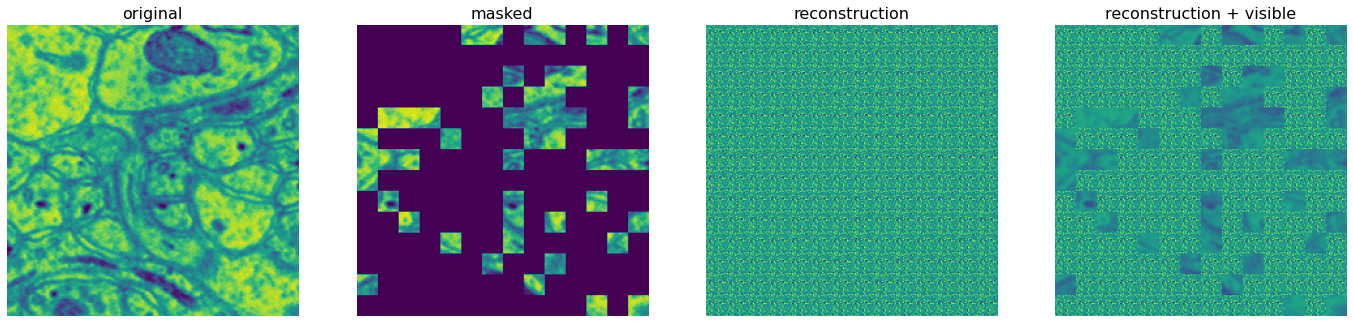

tensor(0.1295, grad_fn=<DivBackward0>)
1
torch.Size([2, 1, 224, 224])
torch.Size([224, 224, 1])
torch.Size([1, 224, 224, 1])


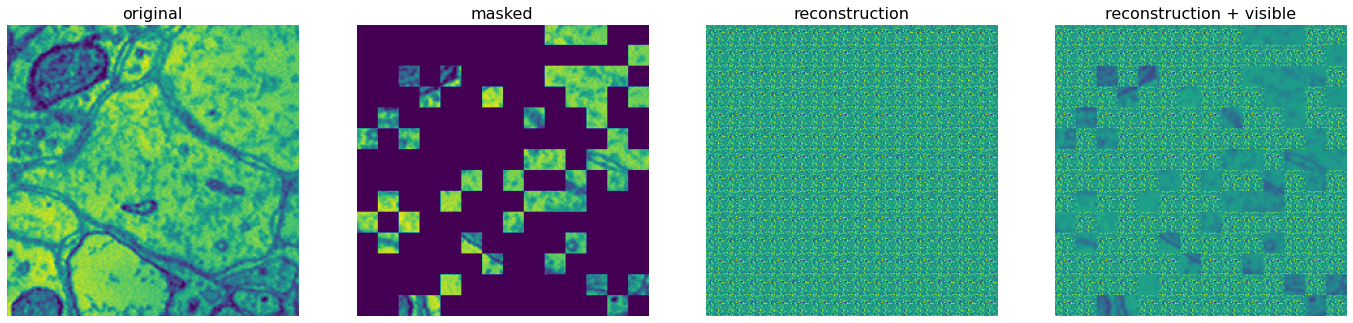

tensor(0.1390, grad_fn=<DivBackward0>)
2
torch.Size([2, 1, 224, 224])
torch.Size([224, 224, 1])
torch.Size([1, 224, 224, 1])


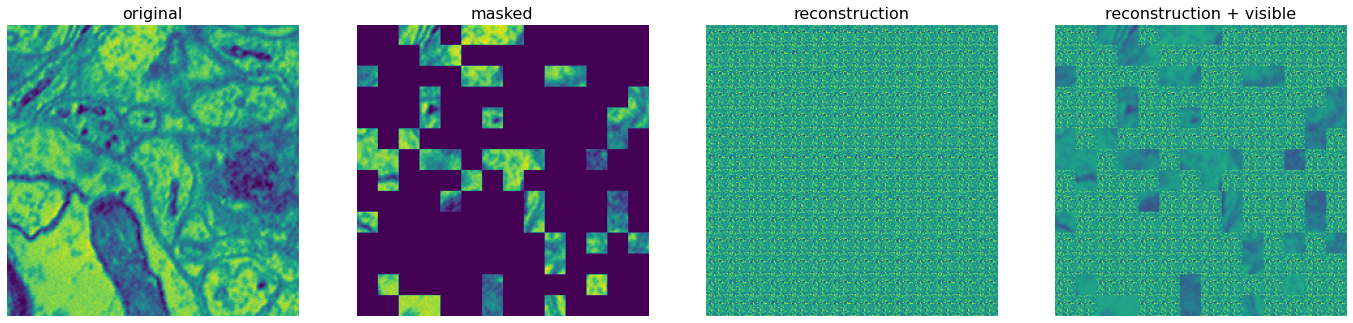

tensor(0.1487, grad_fn=<DivBackward0>)
3
torch.Size([2, 1, 224, 224])
torch.Size([224, 224, 1])
torch.Size([1, 224, 224, 1])


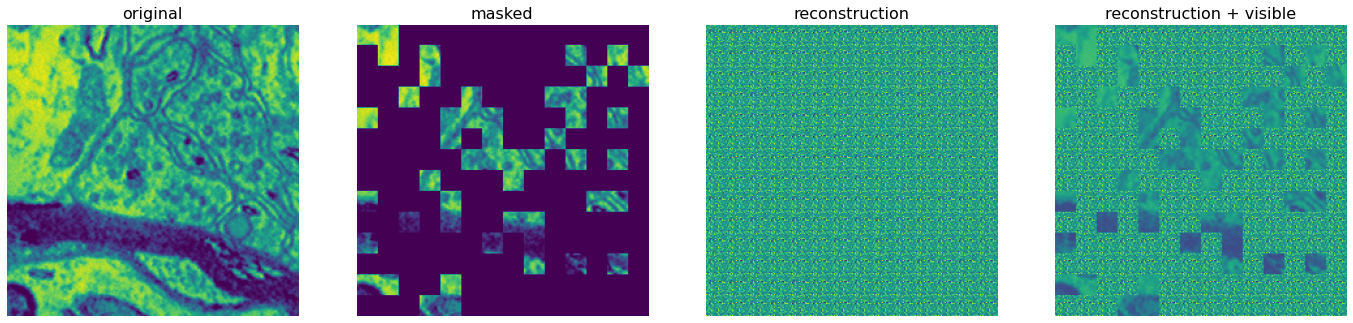

tensor(0.1600, grad_fn=<DivBackward0>)
4
torch.Size([2, 1, 224, 224])
torch.Size([224, 224, 1])
torch.Size([1, 224, 224, 1])


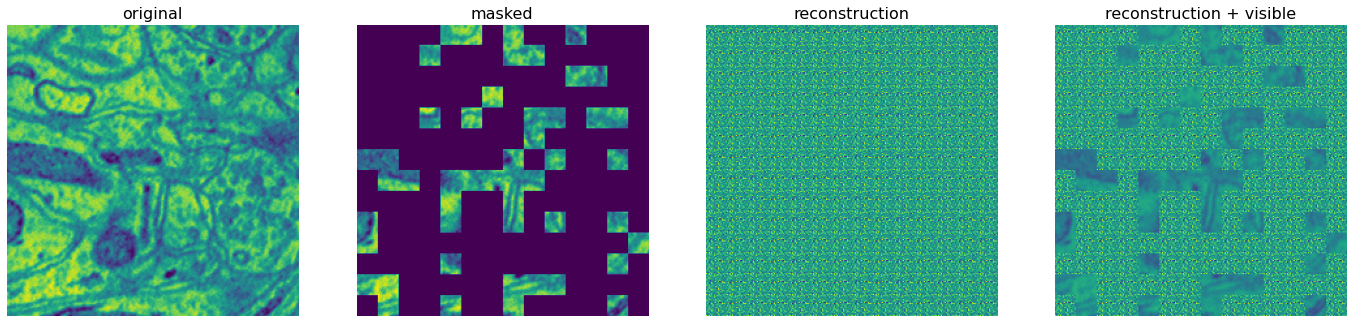

tensor(0.1363, grad_fn=<DivBackward0>)
5
torch.Size([2, 1, 224, 224])
torch.Size([224, 224, 1])
torch.Size([1, 224, 224, 1])


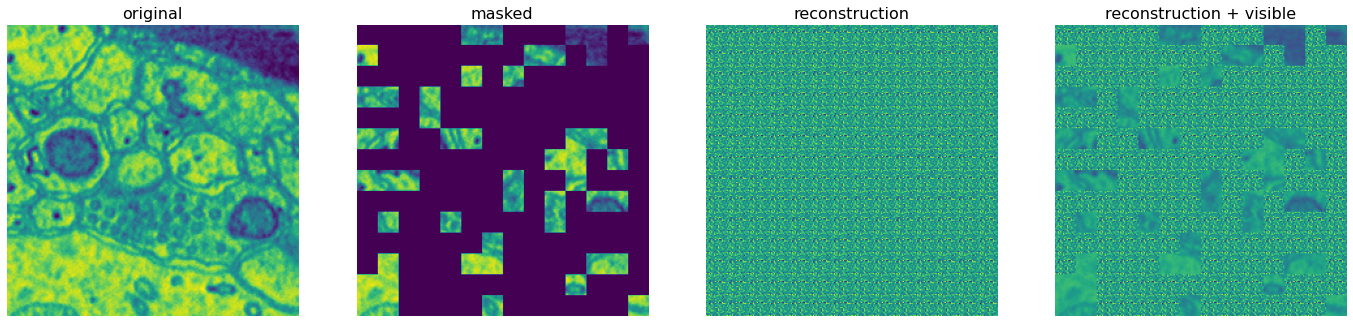

tensor(0.1221, grad_fn=<DivBackward0>)
6
torch.Size([2, 1, 224, 224])
torch.Size([224, 224, 1])
torch.Size([1, 224, 224, 1])


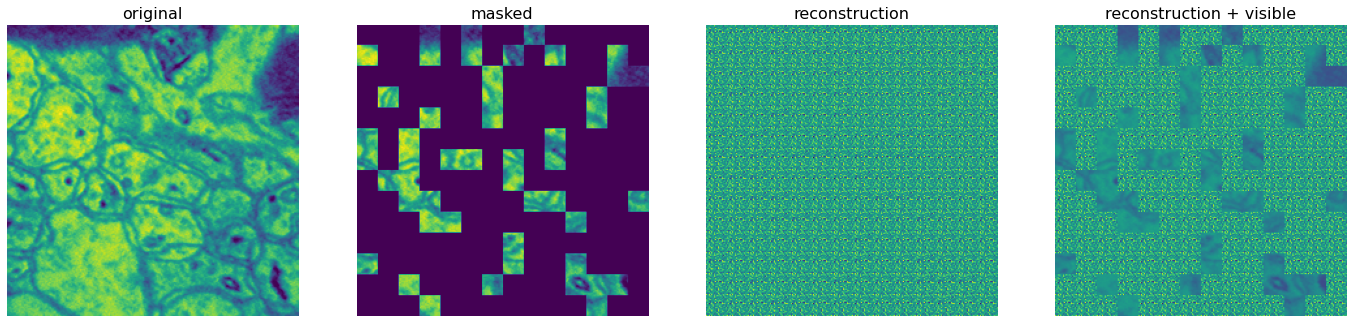

tensor(0.1448, grad_fn=<DivBackward0>)
7
torch.Size([2, 1, 224, 224])
torch.Size([224, 224, 1])
torch.Size([1, 224, 224, 1])


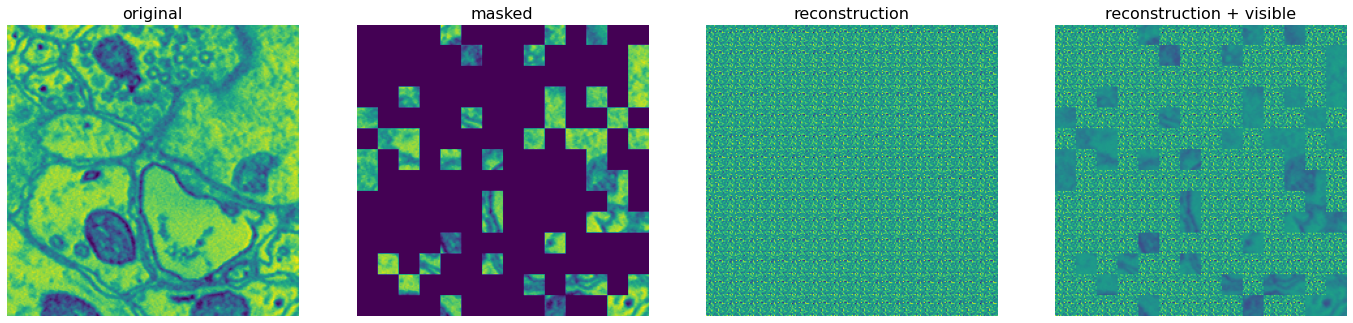

tensor(0.1425, grad_fn=<DivBackward0>)
8
torch.Size([2, 1, 224, 224])
torch.Size([224, 224, 1])
torch.Size([1, 224, 224, 1])


KeyboardInterrupt: 

In [32]:
i=0
for x in val_loader:
    print(x.shape)
#     x = x.to(device)
    x = x[0][0]
    x = x.unsqueeze(dim=2)
    print(x.shape)
#     x = np.stack((x,x,x), axis=2)
    print(run_one_image(x, mae))
    i+=1
    print(i)

In [ ]:
plt.plot(range(len(loss_list)),loss_list, '-')
plt.plot(range(len(vloss_list)),vloss_list, '-')
plt.show()